In [1]:
import torch
from torch import nn,optim
from sklearn.preprocessing import StandardScaler


from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import time
import os


import matplotlib.pyplot as plt
%matplotlib inline

# Configurando hiperparâmetros.
args = {
    'epoch_num': 200,     # Número de épocas.
    'lr': 5e-5,           # Taxa de aprendizado.
    'weight_decay': 5e-4, # Penalidade L2 (Regularização).
    'num_workers': 3,     # Número de threads do dataloader.
    'batch_size': 20,     # Tamanho do batch.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])


cuda


In [ ]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
! unzip Bike-Sharing-Dataset.zip

In [ ]:
!ls


In [ ]:
df = pd.read_csv('hour.csv')
print(len(df))
df.head()

17379


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
torch.manual_seed(1)
indices = torch.randperm(len(df)).tolist()

train_size = int(0.8*len(df))

df_train = df.iloc[indices[:train_size]]
df_test = df.iloc[indices[train_size:]]

display(df_test.head())

df_train.to_csv('bike_train.csv',index=False)
df_test.to_csv('bike_test.csv',index=False)

In [ ]:
class Bicicletinha(Dataset):
  def __init__(self, csv_path, scaler_feat=None, scaler_label=None):
  
    self.dados = pd.read_csv(csv_path).to_numpy()
    
  def __getitem__(self, idx):
    
    sample = self.dados[idx][2:14]
    label  = self.dados[idx][-1:]
    
    
    # converte para tensor
    sample = torch.from_numpy(sample.astype(np.float32))
    label = torch.from_numpy(label.astype(np.float32))


    
    return sample, label
    
  def __len__(self):
    return len(self.dados)

In [ ]:
train_set = Bicicletinha('bike_train.csv')
test_set = Bicicletinha('bike_test.csv')

print('Tamanho do treino: ' + str(len(train_set)) + ' amostras')
print('Tamanho do teste: ' + str(len(test_set)) + ' amostras')

Tamanho do treino: 13903 amostras
Tamanho do teste: 3476 amostras


In [ ]:
# Criando dataloader
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

In [ ]:
for batch in test_loader:
  
  dado, rotulo = batch
  print('## Dimensionalidade do batch ##')
  print(dado.size(), rotulo.size())
  
  break

In [ ]:
class MLP(nn.Module):
  
  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()
    
    self.features = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
    )
    
    self.classifier = nn.Sequential(
        nn.Linear(hidden_size, out_size),
        nn.ReLU(),
    )

  def forward(self, X):
    
    hidden = self.features(X)
    output = self.classifier(hidden)
    
    return output

input_size  = train_set[0][0].size(0)
hidden_size = 128
out_size    = 1

net = MLP(input_size, hidden_size, out_size).to(args['device'])
print(net)

MLP(
  (features): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): ReLU()
  )
)


In [ ]:
criterion = nn.L1Loss().to(args['device'])
optimizer = optim.Adam(net.parameters(),lr=args['lr'],weight_decay = args['weight_decay'])

In [ ]:
def train(train_loader, net, epoch):

  # Training mode
  net.train()
  
  start = time.time()
  
  
  epoch_loss  = []
  for batch in train_loader:
    
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])
    
    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
   
  epoch_loss = np.asarray(epoch_loss)
  
  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))
  
  return epoch_loss.mean()

In [ ]:
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()
  
  start = time.time()
  
  epoch_loss  = []
  
  with torch.no_grad(): 
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
  
      epoch_loss.append(loss.cpu().data)

  epoch_loss = np.asarray(epoch_loss)
  
  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))
  
  return epoch_loss.mean()
    

rodar a rede

In [ ]:
train_losses, test_losses = [], []
for epoch in range(args['epoch_num']):
  
  # Train
  train_losses.append(train(train_loader, net, epoch))
  
  # Validate
  test_losses.append(validate(test_loader, net, epoch))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#################### Train ####################
Epoch 0, Loss: 164.3138 +/- 42.0975, Time: 2.57
********** Validate **********
Epoch 0, Loss: 125.7965 +/- 30.3890, Time: 0.46

#################### Train ####################
Epoch 1, Loss: 130.6107 +/- 25.6430, Time: 2.25
********** Validate **********
Epoch 1, Loss: 126.6351 +/- 24.3811, Time: 0.45

#################### Train ####################
Epoch 2, Loss: 122.8896 +/- 30.2196, Time: 2.38
********** Validate **********
Epoch 2, Loss: 125.2943 +/- 31.5335, Time: 0.49

#################### Train ####################
Epoch 3, Loss: 120.4436 +/- 31.0856, Time: 2.45
********** Validate **********
Epoch 3, Loss: 117.2515 +/- 26.3097, Time: 0.46

#################### Train ####################
Epoch 4, Loss: 118.8115 +/- 24.6739, Time: 2.56
********** Validate **********
Epoch 4, Loss: 114.5222 +/- 28.4489, Time: 0.46

#################### Train ####################
Epoch 5, Loss: 118.3620 +/- 31.7777, Time: 2.57
********** Validate ****

train_losses, test_losses = [], []
for epoch in range(args['epoch_num']):
  
  # Train
  train_losses.append(train(train_loader, net, epoch))
  
  # Validate
  test_losses.append(validate(test_loader, net, epoch))

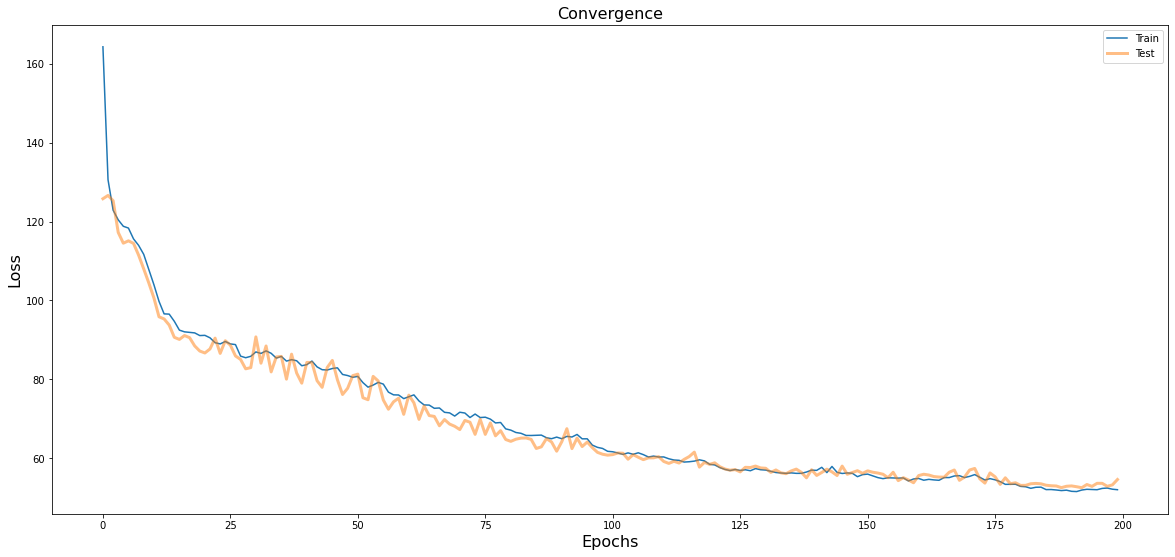

In [ ]:
plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()